In [ ]:
# Install necessary libraries for RAG and NVIDIA integration
%pip install langchain-nvidia-ai-endpoints langchain-community langchain faiss-cpu pandas

In [2]:
import os
from getpass import getpass

# Securely input the NVIDIA API Key
if not os.environ.get("NVIDIA_API_KEY"):
    os.environ["NVIDIA_API_KEY"] = getpass("Enter your NVIDIA API Key: ")

Enter your NVIDIA API Key: ··········


In [3]:
from google.colab import files

print("Please upload your 'wiki_movie_plots_deduped.csv' file:")
uploaded = files.upload()


file_name = list(uploaded.keys())[0]
print(f"File '{file_name}' uploaded successfully!")

Please upload your 'wiki_movie_plots_deduped.csv' file:


Saving wiki_movie_plots_deduped.csv to wiki_movie_plots_deduped (1).csv
File 'wiki_movie_plots_deduped (1).csv' uploaded successfully!


In [4]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
# 1. Basic Info
print("--- Data Overview ---")
df = pd.read_csv(file_name)
print(df.info())

# 2. Check for Missing Values
missing_plots = df['Plot'].isnull().sum()
print(f"\nMissing Plots: {missing_plots}")

# 3. Drop rows with missing plots (Preprocessing)
# This ensures our RAG pipeline doesn't break later
df_clean = df.dropna(subset=['Plot', 'Title']).copy()
print(f"Rows after dropping nulls: {len(df_clean)}")

--- Data Overview ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34886 entries, 0 to 34885
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Release Year      34886 non-null  int64 
 1   Title             34886 non-null  object
 2   Origin/Ethnicity  34886 non-null  object
 3   Director          34886 non-null  object
 4   Cast              33464 non-null  object
 5   Genre             34886 non-null  object
 6   Wiki Page         34886 non-null  object
 7   Plot              34886 non-null  object
dtypes: int64(1), object(7)
memory usage: 2.1+ MB
None

Missing Plots: 0
Rows after dropping nulls: 34886



--- Plot Length Statistics (Words) ---
count    34886.000000
mean       372.493206
std        315.753223
min          2.000000
25%        122.000000
50%        284.000000
75%        581.000000
max       6752.000000
Name: word_count, dtype: float64


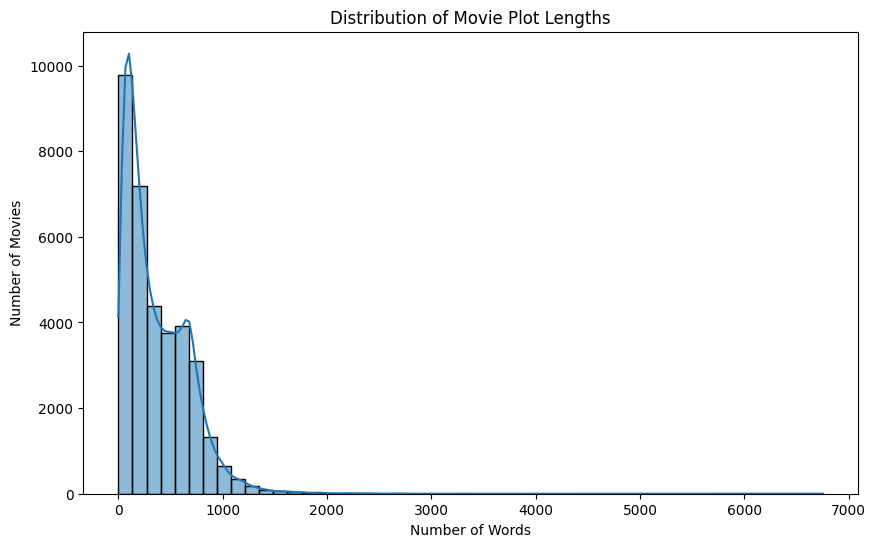


--- Example Short Plot ---
Smith explains:

--- Example Long Plot ---
After a brief introduction to some of the main characters of the story, the beginning sees a group of Rishis, led by Vishvamitra, performing a Yajna in a forest not far from Ayodhya, the Capital of the Kingdom of Kosala. This Yajna, like several before it, is interrupted and destroyed by a group of ...


In [5]:
# 4. Analyze Plot Lengths (Crucial for RAG Chunking)
# Calculate word count for each plot
df_clean['word_count'] = df_clean['Plot'].apply(lambda x: len(str(x).split()))

print("\n--- Plot Length Statistics (Words) ---")
print(df_clean['word_count'].describe())

# 5. Visualize the Distribution
plt.figure(figsize=(10, 6))
sns.histplot(df_clean['word_count'], bins=50, kde=True)
plt.title('Distribution of Movie Plot Lengths')
plt.xlabel('Number of Words')
plt.ylabel('Number of Movies')
plt.show()

# 6. Check a "Short" vs "Long" plot
# This helps you verify if "short" plots are actually useful content
print("\n--- Example Short Plot ---")
print(df_clean.sort_values('word_count').iloc[0]['Plot'])

print("\n--- Example Long Plot ---")
print(df_clean.sort_values('word_count', ascending=False).iloc[0]['Plot'][:300] + "...")

The average is around **300-500 words**(372.493206), our current `chunk_size=1500` (characters) is perfect, because ~4 chars ≈ 1 word.

In [6]:
subset = df.dropna(subset=['Plot', 'Title']).head(500)
print(f"Loaded {len(subset)} movies.")

Loaded 500 movies.


In [7]:
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain_core.documents import Document

splitter = RecursiveCharacterTextSplitter(
    chunk_size=1500,
    chunk_overlap=150,
    length_function=len,
)

#  Create Documents
documents = []
for _, row in subset.iterrows():
    chunks = splitter.split_text(row['Plot'])
    for chunk in chunks:
        doc = Document(
            page_content=chunk,
            metadata={"title": row['Title'], "release_year": row.get('Release Year', 'Unknown')}
        )
        documents.append(doc)

print(f"Total chunks created: {len(documents)}")
print("--- Example Chunk ---")
print(documents[0].page_content[:200] + "...")

Total chunks created: 685
--- Example Chunk ---
A bartender is working at a saloon, serving drinks to customers. After he fills a stereotypically Irish man's bucket with beer, Carrie Nation and her followers burst inside. They assault the Irish man...


In [9]:
from langchain_nvidia_ai_endpoints import NVIDIAEmbeddings
from langchain_community.vectorstores import FAISS

print("Initializing NVIDIA Embeddings (nvidia/nv-embed-v1)...")
embeddings = NVIDIAEmbeddings(model="nvidia/nv-embed-v1", truncate="END")

print("Creating Vector Store (this sends data to NVIDIA)...")
# This creates the In-Memory Vector Store
vector_store = FAISS.from_documents(documents, embeddings)
retriever = vector_store.as_retriever(search_kwargs={"k": 3})

print("Vector Store created successfully!")

Initializing NVIDIA Embeddings (nvidia/nv-embed-v1)...
Creating Vector Store (this sends data to NVIDIA)...
Vector Store created successfully!


In [10]:
query = "What happens in the movie The Great Train Robbery?"
docs = retriever.invoke(query)

print(f"Query: {query}")
print(f"Retrieved {len(docs)} relevant chunks.\n")

for i, doc in enumerate(docs):
    print(f"--- Result {i+1} ({doc.metadata['title']}) ---")
    print(doc.page_content[:300] + "...\n")

Query: What happens in the movie The Great Train Robbery?
Retrieved 3 relevant chunks.

--- Result 1 (The Great Train Robbery) ---
The film opens with two bandits breaking into a railroad telegraph office, where they force the operator at gunpoint to have a train stopped and to transmit orders for the engineer to fill the locomotive's tender at the station's water tank. They then knock the operator out and tie him up. As the tr...

--- Result 2 (From Leadville to Aspen: A Hold-Up in the Rockies) ---
The film features a train traveling through the Rockies and a hold up created by two thugs placing logs on the line. They systematically rob the wealthy occupants at gunpoint and then make their getaway along the tracks and later by a hi-jacked horse and cart....

--- Result 3 (The Little Train Robbery) ---
The next scene shows the gang breaking into a barn. They steal ponies and ride away. Upon reaching the place agreed upon they picket their ponies and leaving them in charge of a trusted 

In [11]:
from langchain_nvidia_ai_endpoints import ChatNVIDIA
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.output_parsers import StrOutputParser

# 1. Setup LLM
llm = ChatNVIDIA(model="meta/llama-3.1-70b-instruct", temperature=0.1)

# 2. Create Prompt
prompt = ChatPromptTemplate.from_messages([
    ("system", "You are a movie expert. Use the context provided to answer the question."),
    ("user", "Context:\n{context}\n\nQuestion: {question}")
])

# 3. Define Chain
# We use a simple chain here for testing (no JSON parser yet, just text)
def format_docs(docs):
    return "\n\n".join([d.page_content for d in docs])

chain = prompt | llm | StrOutputParser()

# 4. Run Chain
question = "Describe the ending of The Great Train Robbery."
retrieved_docs = retriever.invoke(question)
response = chain.invoke({
    "context": format_docs(retrieved_docs),
    "question": question
})

print(f"Question: {question}\n")
print(f"Answer:\n{response}")

Question: Describe the ending of The Great Train Robbery.

Answer:
The ending of The Great Train Robbery shows the entire gang of robbers being rounded up by the police after a lively chase through tall weeds, over a bridge, and up a steep hill. The robbers are forced to jump into a pond to escape, but are eventually caught and tied together with a rope. The final scene shows the bedraggled and crestfallen robbers being led away by the police, with two officers loaded down with the robbers' confiscated revolvers, knives, and cartridge belts.
